In [418]:
import numpy as np
import matplotlib.pyplot as plt
import random, time

#### Plan

Elements: voltage source

Meaningful variables: rotation, position

Noise: rotation of orientation, stretching of shape, etc.

Rest of background must be randomly generated and uniformly distributed, but same density as the image (maybe generate random lines and shapes)

#### Implementation

Each shape stored as a one mask; then just bitwise or each mask together with a zeros array

## Random Number Generation + General Parameters

In [617]:
GRID_SIZE = 1000
CENTER_NOISE_STD_PROPORTION = 0.4
ROT_NOISE_STD = 6
STRETCH_STD = 0.1
MIN_STRETCH, MAX_STRETCH = -0.4, 0.4
ADDITIVE_STD = GRID_SIZE / 500

def get_random_center(lower_padding=0, upper_padding=0, lower_bound=None, upper_bound=None):
    #x, y = random.uniform(0, CENTER_NOISE_STD_PROPORTION*GRID_SIZE), random.gauss(0, CENTER_NOISE_STD_PROPORTION*GRID_SIZE)
    if lower_bound is None and upper_bound is None:
        lower_bound, upper_bound = -GRID_SIZE//2+1+lower_padding, GRID_SIZE//2-1-upper_padding
    x, y = random.uniform(lower_bound, upper_bound), random.uniform(lower_bound, upper_bound)
    return np.round(np.array([x, y])).astype('int32')
    #x, y = constrain(x, lower_bound, upper_bound), constrain(y, lower_bound, upper_bound)
    #return np.round(np.array([x, y])).astype('int32')
def get_random_rotation(lower_bound=-90, upper_bound =90):
    # Range from -90 to 90
    return constrain(random.gauss(0, ROT_NOISE_STD), lower_bound, upper_bound)
def get_random_stretch(lower_bound=MIN_STRETCH, upper_bound=MAX_STRETCH):
    return 1 + constrain(random.gauss(0, STRETCH_STD), lower_bound, upper_bound)
def get_additive_noise():
    return int(random.gauss(0, ADDITIVE_STD))

constrain = lambda val, lower, upper: max(lower, min(upper, val))

## Basic Geometric Shapes

In [679]:
def rotate(points, theta, noisy=False):
    """
    Inputs:
        points - an nx2 NumPy vector, in which each entry is an (x, y) pair
        theta - degrees by which to rotate
    """
    theta = -theta # CHANGE IF CHANGING IMAGE CONVENTION
    if noisy:
        theta += get_random_rotation()
    theta = np.radians(theta)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    result = np.round(rotation_matrix.dot(points.T).T).astype('int32')    
    return result

def rotate_spreads(x_spread, y_spread, theta):
    stretch_arr = np.array([[x_spread, 0],
                           [0, y_spread]])
    return tuple(np.max(rotate(stretch_arr, theta, noisy=False), axis=1))

def stretch(points, x_factor=None, y_factor=None, get_box=False):
    if x_factor is None and y_factor is None:
        x_factor = get_random_stretch()
        y_factor = get_random_stretch()
    stretch_matrix = np.array([
        [x_factor, 0],
        [0, y_factor]
    ])
    result = np.round(stretch_matrix.dot(points.T).T).astype('int32')
    if get_box:
        return np.array([y_factor, x_factor]), result
    return result

def line(length, center, thickness, theta, grid_size, noisy=False):
    """
    Inputs:
        length: overall length of the line, endpoint to endpoint
        theta: counterclockwise angle (degrees) by which the line is rotated
        center: midpoint of the line
        thickness: line is 2*thickness - 1 pixels thick
    """
    center = center.astype('int32')
    if center is None:
        center = get_random_center(length, length)
    grid = np.zeros((grid_size, grid_size))
    points = np.array([[x, y] for x in range(int(-length//2), int(length//2)+1) for y in range(-thickness+1, thickness)])
    points = rotate(points, theta, noisy=noisy)
    if noisy:
        for pt in points:
            grid[pt[1] + center[1] + get_additive_noise()][pt[0] + center[0] + get_additive_noise()] = 1
    else:
        for pt in points:
            grid[pt[1] + center[1]][pt[0] + center[0]] = 1
    return np.roll(grid, (grid_size//2+1, grid_size//2+1), axis=(0, 1))

def line_endpoint(start, end, thickness, grid_size, noisy=False):
    print(start, end)
    length = int(np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2))
    midpoint = (start + end) / 2
    # CHANGE IF CONVENTION CHANGES; negated theta
    theta = -np.degrees(np.arctan((start[1] - end[1]) / (start[0] - end[0])) if start[0] != end[0] else np.pi/2)
    return line(length, midpoint, thickness, theta, grid_size, noisy=noisy)

def circle(radius, center, thickness, theta, grid_size, noisy=False, get_box=False):
    """
    Theta is actually useless here. BUT it makes it conform to the interface for the rest of the functions
    """
    if center is None:
        stretch_padding = (grid_size//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+radius, upper_bound=stretch_padding-thickness-radius)
    plus_epsilon = 2*radius*thickness - thickness**2 # (r+thickness)^2 - r^2
    minus_epsilon = 2*radius*thickness - thickness**2 # r^2 - (r - thickness)^2
    grid_center = np.array([grid_size//2, grid_size//2])
    grid = np.zeros((grid_size, grid_size))
    xx, yy = np.mgrid[-grid_size//2:grid_size//2, -grid_size//2:grid_size//2]
    zero_dists = xx**2 + yy**2
    points = np.argwhere(np.logical_and(zero_dists > radius**2 - minus_epsilon, zero_dists < radius**2 + plus_epsilon))
    points -= (grid_size//2) * np.ones((len(points), 2)).astype('int32')
    
    if noisy:
        if get_box:
            stretch_factors, stretched_points = stretch(points, get_box=get_box)
        else:
            stretched_points = stretch(points, get_box=get_box)
        for pt in stretched_points:
            grid[pt[0] + center[1] + get_additive_noise()][pt[1]+center[0]+get_additive_noise()] = 1
    else:
        for pt in points:
            grid[pt[0] + center[1]][pt[1]+center[0]] = 1
    result = np.roll(grid, (grid_size//2, grid_size//2), axis=(0, 1))
    if get_box:
        #print(stretch_factors)
        return 2*radius*stretch_factors, result # return max x_width, y_width
    return result

## Composite Geometric Shapes

Plus, arrow, triangle

In [619]:
def plus_mask(size, center, thickness, theta, grid_size, noisy=False):
    if center is None:
        center = get_random_center(size, size)
    if noisy:
        horizontal = line(size, center + np.array([get_additive_noise(), get_additive_noise()]), thickness, 0, grid_size, noisy=noisy)
        vertical = line(size, center + np.array([get_additive_noise(), get_additive_noise()]), thickness, 90, grid_size, noisy=noisy)
    else:
        horizontal = line(size, center, thickness, 0, grid_size, noisy=noisy)
        vertical = line(size, center, thickness, 90, grid_size, noisy=noisy)        
    return np.logical_or(horizontal, vertical)

def arrow(size, center, thickness, theta, grid_size, noisy=False):
    # Allow for arbitrary centers to add to background data and be more robust against false positives
    # default points downwards
    if center is None:
        center = get_random_center(size, size)
    grid = line(size, center, thickness, 90, grid_size, noisy=noisy)
    OTHER_LINE_RATIO, ENDPOINT_NOISE_RATIO = 0.4, 10
    other_size = OTHER_LINE_RATIO*size
    if noisy:
        left_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([-other_size/2+get_additive_noise()*ENDPOINT_NOISE_RATIO,
                                               -other_size*(1-np.sqrt(3)/2) + get_additive_noise()*ENDPOINT_NOISE_RATIO]),
                             thickness, grid_size)
        right_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([other_size/2+get_additive_noise()*ENDPOINT_NOISE_RATIO,
                                               -other_size*(1-np.sqrt(3)/2) + get_additive_noise()*ENDPOINT_NOISE_RATIO]),
                              thickness, grid_size)
    else:
        left_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([-other_size/2,
                                               -other_size*(1-np.sqrt(3)/2)]),
                             thickness, grid_size)
        right_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([other_size/2,
                                               -other_size*(1-np.sqrt(3)/2)]),
                              thickness, grid_size)
    points = np.argwhere(np.logical_or(grid, np.logical_or(left_line, right_line)))
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

## Circuit Elements

Voltage sources, current sources, resistors, capacitors

In [719]:
def source_mask(size, center, thickness, theta, grid_size, source_func, noisy=False, get_box=False):
    """
    source_func takes the rest of the parameters and returns a grid to overlay onto the source
    """
    # defaults to vertical, facing down
    if center is None:
        stretch_padding = (GRID_SIZE//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+size, upper_bound=stretch_padding-thickness-size)
    if noisy:
        theta += get_random_rotation()
    if get_box:
        widths, grid = circle(size, center, thickness, theta, grid_size, noisy=noisy, get_box=get_box)
    else:
        grid = circle(size, center, thickness, theta, grid_size, noisy=noisy, get_box=get_box)
    grid = np.logical_or(grid,
                         source_func(size,
                                   center+np.array([get_additive_noise(), get_additive_noise()]),
                                   thickness, theta, grid_size, noisy=noisy))
    points = np.argwhere(grid)
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    result = np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))
    if get_box:
        max_factor = np.max(widths)
        return np.array([center[0]+grid_size//2, center[1]+grid_size//2, max_factor, max_factor]), result
    return result

def voltage_source_func(size, center, thickness, theta, grid_size, noisy=False):
    SIZE_RATIO, OFFSET_RATIO = constrain(random.gauss(0.7, 0.1), 0.15, 0.85), constrain(random.gauss(0.3, 0.1), 0.2, 0.4)
    if noisy:
        return np.logical_or(plus_mask(size*SIZE_RATIO,
                                   center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                                   thickness, 0, grid_size, noisy=noisy),
                            line(size*SIZE_RATIO,
                              center+np.array([get_additive_noise(), get_additive_noise() - \
                                               constrain(random.gauss(1.5, 0.3), 0.75, 2.25)*int(OFFSET_RATIO*size)]),
                              thickness, 0, grid_size, noisy=noisy))
    else:
        return np.logical_or(plus_mask(size,
                                   center+np.array([0, int(OFFSET_RATIO*size)]),
                                   thickness, theta, grid_size, noisy=noisy),
                            line(size,
                              center-np.array([0, int(OFFSET_RATIO*size)]),
                              thickness, theta, grid_size, noisy=noisy))

def current_source_func(size, center, thickness, theta, grid_size, noisy=False):
    SIZE_RATIO, OFFSET_RATIO = constrain(random.gauss(0.5, 0.1), 0.15, 0.85), constrain(random.gauss(0, 0.1), -0.1, 0.1)
    if noisy:
        return arrow(size, center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                    thickness, 0, grid_size, noisy=noisy)
    else:
        return arrow(size, center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                    thickness, 0, grid_size, noisy=noisy)
def voltage_source_mask(size, center, thickness, theta, grid_size, noisy=False, get_box=False):
    return source_mask(size, center, thickness, theta, grid_size, voltage_source_func, noisy=noisy, get_box=get_box)

def current_source_mask(size, center, thickness, theta, grid_size, noisy=False, get_box=False):
    return source_mask(size, center, thickness, theta, grid_size, current_source_func, noisy=noisy, get_box=get_box)

def capacitor(size, center, thickness, theta, grid_size, noisy=False, get_box=False):
    # default is vertical (capacitor plates parallel to x axis)
    assert size > thickness, 'Draw thinner lines or make the capacitor larger!'
    GAP_RATIO = constrain(random.gauss(0.3, 0.1), 0.05, 0.5)
    gap = (size - thickness) * random.random() * GAP_RATIO + thickness
    if center is None:
        center = get_random_center(size+2*(gap+thickness), size+2*(gap+thickness))
    top_center = center + np.array([0, -gap]) + (np.array([get_additive_noise(), get_additive_noise()]) if noisy else 0)
    bottom_center = center + np.array([0, gap]) + (np.array([get_additive_noise(), get_additive_noise()]) if noisy else 0)
    top_plate = line(size, top_center, thickness, 0, grid_size, noisy=noisy)
    bottom_plate = line(size, bottom_center, thickness, 0, grid_size, noisy=noisy)
    top_wire = line_endpoint(top_center, top_center-np.array([0, 0.6*(size-gap-2*thickness)]),
                             thickness, grid_size, noisy=noisy)
    bottom_wire = line_endpoint(bottom_center, bottom_center+0.6*np.array([0, (size-gap-2*thickness)]),
                                thickness, grid_size, noisy=noisy)
    grid = np.logical_or(top_plate, bottom_plate)
    grid = np.logical_or(grid, np.logical_or(top_wire, bottom_wire))
    points = np.argwhere(grid)
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    if get_box:
        theta = np.radians(theta)
        #x_spread = int(max(1.5*size*abs(np.cos(theta)), (2*gap+2*thickness)*abs(np.sin(theta))))
        #y_spread = int(max(1.5*size*abs(np.sin(theta)), (2*gap+2*thickness)*abs(np.cos(theta))))
        #x_spread, y_spread = int(max(abs(total_height*np.sin(np.radians(theta))), max_x-min_x)), \
        #                    int(max(abs(total_height*np.cos(np.radians(theta))), max_x-min_x))
        x_spread, y_spread = size+2*(gap+thickness), size+2*(gap+2*thickness)
        center += grid_size//2
        return np.array([center[0], center[1], x_spread, y_spread]), np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

In [720]:
def resistor(size, center, thickness, theta, grid_size, noisy=False, get_box=False):
    """
    In this case, size refers to the LENGTH of the resistor; the width is linearly related + function of # of squiggles
    A squiggle is a single FULL spanning line; the half line at beginning and end don't count
    Default is vertical to be consistent with others
    """
    MIN_THETA, MAX_THETA = 45, 80
    ADDITIVE_NOISE_RATIO = 5
    MIN_SQUIGGLES, MAX_SQUIGGLES = 2, 5 # each squiggle is one half ridge
    num_squiggles = MIN_SQUIGGLES + int(random.random() * (MAX_SQUIGGLES - MIN_SQUIGGLES))
    height_per_squiggle = size / (num_squiggles+1)
    grid = np.zeros((grid_size, grid_size))
    
    min_x, max_x = float('inf'), -float('inf')
    
    if noisy:
        squiggle_heights = np.array([height_per_squiggle+get_additive_noise()*ADDITIVE_NOISE_RATIO for _ in range(num_squiggles)])
        squiggle_heights = np.concatenate((np.array([0, (height_per_squiggle+get_additive_noise()*ADDITIVE_NOISE_RATIO)/2]),
                                      squiggle_heights, np.array([(height_per_squiggle+get_additive_noise()*ADDITIVE_NOISE_RATIO/2)])),
                                     axis=0)
    else:
        squiggle_heights = np.array([height_per_squiggle for _ in range(num_squiggles)])
        squiggle_heights = np.concatenate((np.array([0, height_per_squiggle]),
                                      squiggle_heights, np.array([height_per_squiggle])),
                                     axis=0)
    squiggle_offsets = np.cumsum(squiggle_heights)
    total_height = squiggle_offsets[-1] + 1
    if center is None:
        center = get_random_center(total_height, total_height)
    widths = []
    for i in range(len(squiggle_heights)):
        theta_rad = np.radians((MAX_THETA - MIN_THETA)*random.random() + MIN_THETA)
        squiggle_inverse_slope = np.arctan(theta_rad)
        if i % 2 == 0:
            widths.append(squiggle_heights[i]*squiggle_inverse_slope)
        else:
            widths.append(-squiggle_heights[i]*squiggle_inverse_slope)
        max_x, min_x = max(max_x, widths[-1]), min(min_x, widths[-1])
    point_offsets = np.array([[dx, dy - total_height // 2] for dx, dy in zip(widths, squiggle_offsets)])
    grid = np.zeros((grid_size, grid_size))
    for i in range(len(point_offsets)-1):
        grid = np.logical_or(grid, line_endpoint(point_offsets[i], point_offsets[i+1], thickness, grid_size, noisy=noisy))
    points = np.argwhere(grid)
    points_demeaned = points - grid_size//2
    rotated = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    if get_box:
        x_spread, y_spread = int(max(abs(total_height*np.sin(np.radians(theta))), max_x-min_x)), \
                            int(max(abs(total_height*np.cos(np.radians(theta))), max_x-min_x))
        return np.array([center[0]+grid_size//2,center[1]+grid_size//2, x_spread, y_spread]), \
                np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

## Convenience/Visualization Functions

In [721]:
def draw_bounding_box(img, w, epsilon=5):
    """
    Mutatively draws a bounding box onto the given image
        w is the box descriptor array
    """
    GRID_SIZE = len(img)
    central = (np.array([w[0], w[1]])).astype('int32')
    w = w.astype('int32')
    w = np.abs(w)
    img[central[1]-w[3]//2:central[1]+w[3]//2, central[0]-w[2]//2-epsilon:central[0]-w[2]//2+epsilon] = 1
    img[central[1]-w[3]//2:central[1]+w[3]//2, central[0]+w[2]//2-epsilon:central[0]+w[2]//2+epsilon] = 1
    img[central[1]+w[3]//2-epsilon:central[1]+w[3]//2+epsilon, central[0]-w[2]//2:central[0]+w[2]//2] = 1
    img[central[1]-w[3]//2-epsilon:central[1]-w[3]//2+epsilon, central[0]-w[2]//2:central[0]+w[2]//2] = 1

[   0. -120.] [-31.92849109 -80.        ]
[-31.92849109 -80.        ] [ 37.56462948 -40.        ]
[ 37.56462948 -40.        ] [-35.3498869   0.       ]
[-35.3498869   0.       ] [26.68267073 40.        ]
[26.68267073 40.        ] [-37.81183889  80.        ]
[-37.81183889  80.        ] [ 36.37649951 120.        ]
[687 740 154 184]


[]

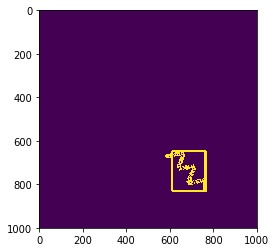

In [733]:
resw, res = resistor(GRID_SIZE//5, None, GRID_SIZE//100, 140, GRID_SIZE, noisy=False, get_box=True)
print(resw)
draw_bounding_box(res, resw)
plt.imshow(res)
plt.plot()

[428.         424.         427.03895805 427.03895805]


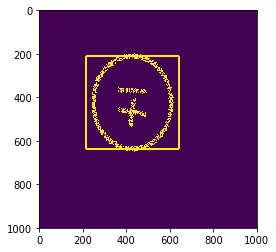

In [753]:
GRID_SIZE=1000
w, v = voltage_source_mask(GRID_SIZE//5, None, GRID_SIZE//100, 0, GRID_SIZE, noisy=True, get_box=True)
print(w)
draw_bounding_box(v, w, epsilon=5)
plt.imshow(v)
plt.show()

[-131.    1.] [-191.        -129.7179677]
[-131.    1.] [ -91.        -109.7179677]
[369.         406.         438.88530523 438.88530523]


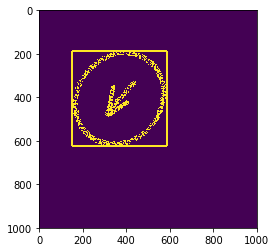

In [764]:
wcs, cs = current_source_mask(GRID_SIZE//5, None, GRID_SIZE//100, 45, GRID_SIZE, noisy=True, get_box=True)
print(wcs)
draw_bounding_box(cs, wcs)
plt.imshow(cs)
plt.show()

[-124.          156.58618932] [-124.           69.23447573]
[-125.          224.41381068] [-125.          311.76552427]
[372.         689.         288.82762137 308.82762137]


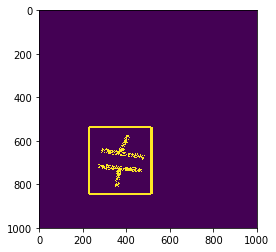

In [762]:
capw, cap = capacitor(GRID_SIZE//5, None, GRID_SIZE//100, 0, GRID_SIZE, noisy=True, get_box=True)
draw_bounding_box(cap, capw)
print(capw)
plt.imshow(cap)
plt.show()

### Putting it All Together
Now we populate the grid with numerous random shapes, supplying the labels as well.

In [727]:
def populated_grid(num_items, grid_size):
    grid = np.zeros((grid_size*grid_size))
    grid[:int(NOISE_DENSITY*grid_size*grid_size)] = 1
    np.random.shuffle(grid)
    grid = np.reshape(grid, (grid_size, grid_size))
    all_functions = [resistor, capacitor, voltage_source_mask, current_source_mask, circle, arrow, plus_mask, line_endpoint]
    circuit_elt_functions = [resistor, capacitor, voltage_source_mask, current_source_mask]
    geometric_functions = [circle, arrow, plus_mask, line_endpoint]
    descs = []
    for _ in range(num_items):
        size = int(constrain(random.gauss(ELT_SIZE_MEAN, ELT_SIZE_STD), ELT_SIZE_MIN, ELT_SIZE_MAX))
        thickness = int(constrain(random.gauss(THICKNESS_MEAN, THICKNESS_STD), THICKNESS_MIN, THICKNESS_MAX))
        func_choice = random.choice(range(len(all_functions)))
        theta_choice = random.choice(range(4))
        theta = 90 * theta_choice
        func = all_functions[func_choice]
        if func in circuit_elt_functions:
            w, shape = func(size, None, thickness, theta, grid_size, noisy=True, get_box=True)
            draw_bounding_box(shape, w, epsilon=5)
            w = np.array([func_choice*4+theta_choice] + list(w))
            descs.append(w.astype('int32'))
        elif func is line_endpoint:
            get_pt = lambda: np.array([random.choice(range(0, grid_size-50)), random.choice(range(0, grid_size-50))])
            pt1, pt2 = get_pt(), get_pt()
            shape = line_endpoint(pt1, pt2, thickness, grid_size, noisy=True)
        else:
            shape = func(size, None, thickness, theta, grid_size, noisy=True)
        grid = np.logical_or(grid, shape)
    print(descs)
    plt.imshow(grid)
    plt.show()

In [729]:
GRID_SIZE = 1000
CENTER_NOISE_STD_PROPORTION = 0.4
ROT_NOISE_STD = 6
STRETCH_STD = 0.1
MIN_STRETCH, MAX_STRETCH = -0.4, 0.4
ADDITIVE_STD = GRID_SIZE / 500

ELT_SIZE_MEAN_PROP = 0.15
ELT_SIZE_STD_PROP = 0.025
ELT_SIZE_MIN_PROP = 0.1
ELT_SIZE_MAX_PROP = 0.22

ELT_SIZE_MEAN = GRID_SIZE*ELT_SIZE_MEAN_PROP
ELT_SIZE_STD = GRID_SIZE*ELT_SIZE_STD_PROP
ELT_SIZE_MIN = GRID_SIZE*ELT_SIZE_MIN_PROP
ELT_SIZE_MAX = GRID_SIZE*ELT_SIZE_MAX_PROP

THICKNESS_MEAN_PROP = 0.01
THICKNESS_STD_PROP = 0.003
THICKNESS_MIN_PROP = 0.005
THICKNESS_MAX_PROP = 0.015

THICKNESS_MEAN = GRID_SIZE*THICKNESS_MEAN_PROP
THICKNESS_STD = GRID_SIZE*THICKNESS_STD_PROP
THICKNESS_MIN = GRID_SIZE*THICKNESS_MIN_PROP
THICKNESS_MAX = GRID_SIZE*THICKNESS_MAX_PROP

NOISE_DENSITY = 0.05

[-167.  -23.] [-204.6         -99.39539771]
[-167.  -23.] [-139.4        -109.39539771]
[932 745] [1146  841]
[168.   82.5] [123.8        -42.16386238]
[168.   82.5] [242.2        -22.16386238]
[1417   91] [410 537]
[1363  564] [1336   66]
[array([ 14, 917, 729, 424, 424])]


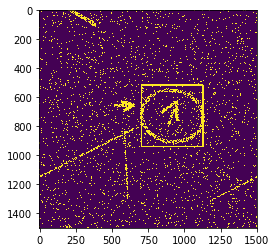

In [748]:
populated_grid(5, 1500)